# Injecting signals starting from existing RAW files
This tutorial walks through importing GUPPI RAW data and adding signals on top.

If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. Once you have CuPy installed, to enable GPU acceleration you must set `SETIGEN_ENABLE_GPU` to '1' in the shell or in Python via `os.environ`. It can also be useful to set `CUDA_VISIBLE_DEVICES` to specify which GPUs to use.

In [1]:
# !pip install cupy-cuda110

In [2]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import setigen as stg

In [4]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

We can quickly make a RAW file with only noise to demonstrate:

In [5]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2,
                              seed=10)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

for stream in antenna.streams:
    stream.add_noise(v_mean=0, 
                     v_std=1)
    
rvb.record(output_file_stem='example_snr',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'TELESCOP': 'GBT'},
           verbose=False)

!rawspec -f 1024 -t 4 -d . example_snr

Blocks: 100%|██████████| 1/1 [01:55<00:00, 115.44s/it]

working stem: example_snr
opening file: example_snr.0000.raw


opening file: example_snr.0001.raw [No such file or directory]
output product 0: 128 spectra


Plotting the results:

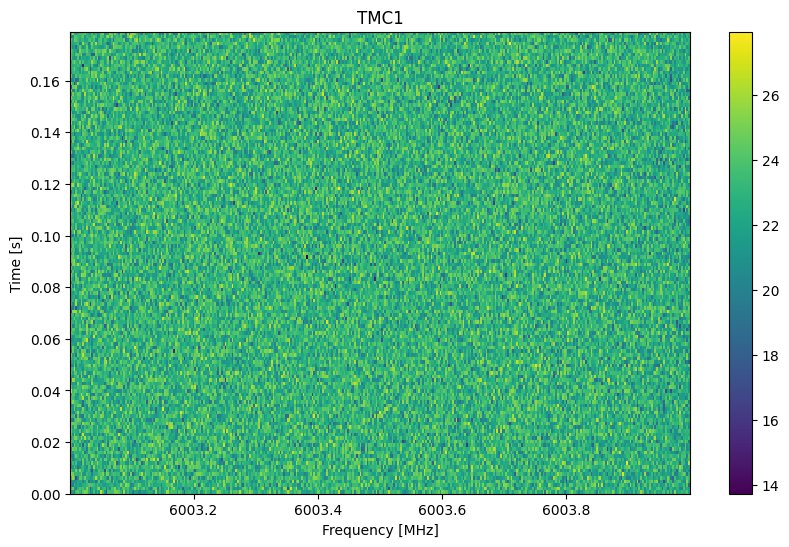

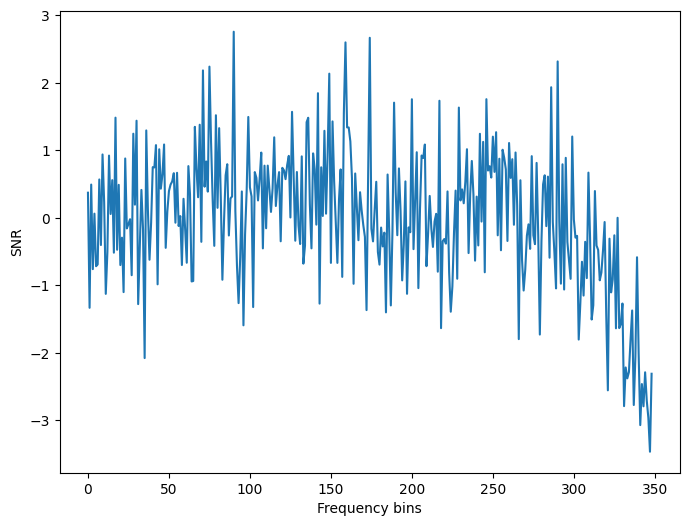

In [6]:
wf = bl.Waterfall('example_snr.rawspec.0000.fil',
                  f_start=6003.0,
                  f_stop=6004.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

## Creating a new voltage backend that imports existing data

First, we need to construct the Antenna with the right numbers, which we can get from the RAW header. We use `stg.voltage.get_raw_params` to retrieve a dictionary with relevant parameters from the header, and pass it into the Antenna instantiation via argument unpacking. Note that this function requires `start_chan` to calculate the correct starting frequency; the header doesn't store this information.

In [7]:
start_chan = 0
input_file_stem = 'example_snr'

raw_params = stg.voltage.get_raw_params(input_file_stem=input_file_stem,
                                        start_chan=start_chan)

antenna = stg.voltage.Antenna(sample_rate=sample_rate,
                              **raw_params)

To start from existing RAW data, we initialize the voltage backend slightly differently, using the `RawVoltageBackend.from_data()` class method. We construct a new filterbank as well. Note that we don't add a requantizer; that will be initialized automatically based on the existing RAW data!

In [8]:
filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

rvb = stg.voltage.RawVoltageBackend.from_data(input_file_stem=input_file_stem,
                                              antenna_source=antenna,
                                              filterbank=filterbank,
                                              start_chan=start_chan,
                                              num_subblocks=32)

Let's add some signals and record. These will be the same as in the `04_raw_file_gen_snr.ipynb` notebook. Here, we actually set `digitize=False` when recording -- this makes sure that we skip the real voltage digitizing step when we only have signals populating the voltages. In other words, if we apply the normal digitization step, which assumes an overall Gaussian noise distribution, onto only signal voltages, it may distort the response and intensities. Turning this off makes it easier to inject a signal at a desired level / intensity.

In [9]:
fftlength = 1024
signal_level = stg.voltage.get_level(snr=10, 
                                     raw_voltage_backend=rvb,
                                     fftlength=fftlength,
                                     num_blocks=1,
                                     length_mode='num_blocks')

for f_start in np.linspace(6003.1e6, 6003.9e6, 9):
    leakage_factor = stg.voltage.get_leakage_factor(f_start, rvb, fftlength)
    print(f'{f_start/1e6:.4f} MHz leakage factor: {leakage_factor:.3f}')
    
    for stream in antenna.streams:
        # There's actually no noise present, but we set levels assuming a background noise_std of 1
        level = 1 * leakage_factor * signal_level
        stream.add_constant_signal(f_start=f_start, 
                                   drift_rate=0*u.Hz/u.s, 
                                   level=level)

rvb.record(output_file_stem='example_snr_input',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'TELESCOP': 'GBT'},
           digitize=False,
           verbose=False)

!rawspec -f 1024 -t 4 -d . example_snr_input

6003.1000 MHz leakage factor: 1.487
6003.2000 MHz leakage factor: 1.514
6003.3000 MHz leakage factor: 1.392
6003.4000 MHz leakage factor: 1.295
6003.5000 MHz leakage factor: 1.217
6003.6000 MHz leakage factor: 1.154
6003.7000 MHz leakage factor: 1.105
6003.8000 MHz leakage factor: 1.066
6003.9000 MHz leakage factor: 1.037


Blocks: 100%|██████████| 1/1 [02:48<00:00, 168.66s/it]

working stem: example_snr_input
opening file: example_snr_input.0000.raw


opening file: example_snr_input.0001.raw [No such file or directory]
output product 0: 128 spectra


## Taking a look

Using `blimpy` and `stg.Frame` to open the resulting filterbank file and plot the data:

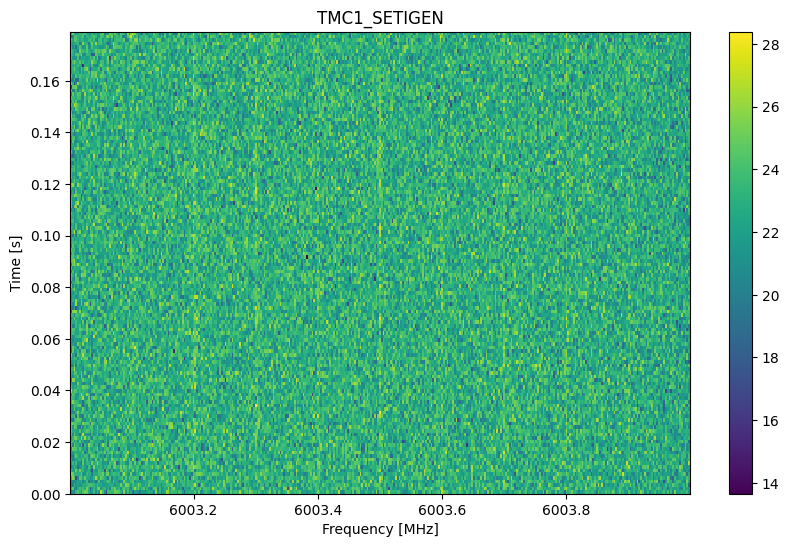

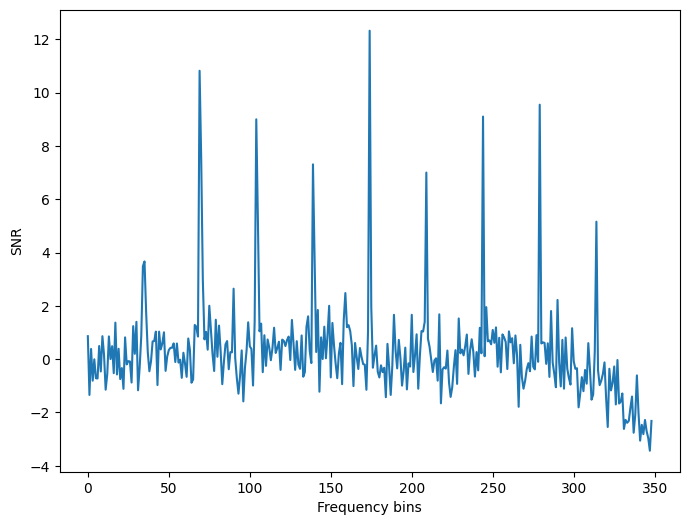

In [10]:
wf = bl.Waterfall('example_snr_input.rawspec.0000.fil',
                  f_start=6003.0,
                  f_stop=6004.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()
